<a href="https://colab.research.google.com/github/rishiiCoder/chemvae/blob/main/rishimolvaeprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [ ]:
!pip install rdkit

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
!conda install openbabel

Channels:
 - conda-forge
 - bioconda
Platform: linux-64
Solving environment: / - \ | / warning  libmamba Added empty dependency for problem type SOLVER_RULE_UPDATE
- \ | / - \ | failed

LibMambaUnsatisfiableError: Encountered problems while solving:
  - package libsolv-0.7.30-h3509ff9_0 requires libzlib >=1.3.1,<2.0a0, but none of the providers can be installed

Could not solve for environment specs
The following packages are incompatible
├─ mamba >=1.5.12  is installable with the potential options
│  ├─ mamba [1.5.12|2.0.0|...|2.0.5] would require
│  │  ├─ libmamba [2.0.0 h188e5ea_0|2.0.0 hf72d635_1|...|2.0.5 hf72d635_0], which requires
│  │  │  └─ libsolv >=0.7.30,<0.8.0a0 , which requires
│  │  │     └─ libzlib >=1.3.1,<2.0a0  with the potential options
│  │  │        ├─ libzlib 1.3.1 would require
│  │  │        │  └─ zlib 1.3.1 *_1, which can be installed;
│  │  │        ├─ libzlib 1.3.1 would require
│  │  │        │  └─ zlib 1.3.1 *_2, which can be instal

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection

In [ ]:
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit import Chem
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


DATA PREPROCESSING FILE CREATION

In [ ]:
import h5py
import numpy as np
import pandas as pd
import os
import json

max_smiles_len = 42
original_csv = 'drive/My Drive/data/rishimolecules.csv'


def csv_to_ohe_csv(smiles_df, data_signature, charset, max_smiles_len=max_smiles_len, dataset_type='train'):

    df = smiles_df

    # Save one-hot encoded CSVs for train and test
    num_chars = len(charset)
    total_rows = len(df) * max_smiles_len

    # Preallocate a large numpy array
    ohe_array = np.zeros((total_rows, num_chars), dtype=np.float32)

    # Build the index for characters in charset
    char_to_index = {char: i for i, char in enumerate(charset)}

    # Fill the array
    row_idx = 0
    for smiles in df['Smiles']:
        padded_smiles = smiles + ' ' * (max_smiles_len - len(smiles))
        for char in padded_smiles:
            if char in charset:
                ohe_array[row_idx, char_to_index[char]] = 1.0
            row_idx += 1
            if row_idx >= total_rows:  # Safety check to prevent out-of-bounds access
                break
        if row_idx >= total_rows:  # Break the outer loop if limit is reached
            break

    # Convert the numpy array to DataFrame and save
    ohe_df = pd.DataFrame(ohe_array, columns=range(num_chars))
    ohe_csvfile = f'drive/My Drive/data/ohe_data_{dataset_type}_{data_signature}.csv'
    ohe_df.to_csv(ohe_csvfile, index=False)
    print(f"Saved one-hot encoded CSV to {ohe_csvfile}")


def ohe_csvs_to_h5(data_signature):
    ohe_csvfiles = [f'drive/My Drive/data/charset_{data_signature}.csv',
                    f'drive/My Drive/data/ohe_data_train_{data_signature}.csv',
                    f'drive/My Drive/data/ohe_data_test_{data_signature}.csv']

    metadata_file = f'drive/My Drive/data/metadata_{data_signature}.json'
    # Load metadata for reshaping
    with open(metadata_file, 'r') as meta_file:
        metadata = json.load(meta_file)

    h5file = os.path.join(f'drive/My Drive/data/processed_{data_signature}.h5')
    with h5py.File(h5file, 'w') as f:
        for csv in ohe_csvfiles:
            if 'charset' in csv:
                key = 'charset'
            if 'data_train' in csv:
                key = 'data_train'
            if 'data_test' in csv:
                key = 'data_test'
            print(f"Processing key: {key}")

            # Load CSV
            df = pd.read_csv(csv, header=None if key == "charset" else 0)

            if key == "charset":
                # Encode charset as fixed-size byte strings
                data = df.iloc[0].astype(str).apply(lambda x: x.encode('utf-8')).to_numpy(dtype="S1")
            else:
                # Load data as float32 for other datasets
                data = df.to_numpy(dtype=np.float32)
                original_shape = tuple(metadata[key]['original_shape'])
                data = data.reshape(original_shape)

            # Save dataset
            f.create_dataset(key, data=data)
            print(f"Saved {key} to {h5file}, shape: {data.shape}")


def original_csv_to_ohe_h5(original_csv, max_smiles_len=max_smiles_len, charset=None):
    df = pd.read_csv(original_csv)

    # save a copy of full.csv without records that have smiles longer than max_smiles_len
    df = df[df['Smiles'].str.len() < max_smiles_len]

    if charset is None:
        charset = sorted(set(''.join([' '] + list(df['Smiles']))))

    data_len = len(df)
    print(f'original data length: {data_len}')

    train_len = int(len(df)*0.8)
    print(f'train length: {train_len}')

    test_len = len(df) - train_len
    print(f'test length: {test_len}')

    charset_len = len(charset)
    print(f'charset length: {len(charset)}')

    data_signature = f'{data_len}_{max_smiles_len}_{charset_len}'
    print(f'data signature: {data_signature}')

    # Save charset
    pd.DataFrame([charset]).to_csv(f'drive/My Drive/data/charset_{data_signature}.csv', index=False, header=False)

    # Save full csv
    df.to_csv(f'drive/My Drive/data/full_{max_smiles_len}_len.csv', index=False)

    # Shuffle Data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # make metadata file for the new csv
    metadata = {}
    metadata['charset'] = {'original_shape': [charset_len, 1]}
    metadata['data_train'] = {'original_shape': [train_len, max_smiles_len, charset_len]}
    metadata['data_test'] = {'original_shape': [test_len, max_smiles_len, charset_len]}
    with open(f'drive/My Drive/data/metadata_{data_signature}.json', 'w') as f:
        json.dump(metadata, f)

    # make data_train.csv
    train_df = df.iloc[:train_len]
#    train_df.to_csv(f'data/data_train_{data_signature}.csv', index=False, header=True)

    # make data_test.csv
    test_df = df.iloc[train_len:]
#    test_df.to_csv(f'data/data_test_{data_signature}.csv', index=False, header=True)

    # Save one-hot encoded CSVs for train and test
    csv_to_ohe_csv(train_df, data_signature, charset, max_smiles_len, dataset_type='train')
    csv_to_ohe_csv(test_df, data_signature, charset, max_smiles_len, dataset_type='test')

    # make h5 file
    ohe_csvs_to_h5(data_signature)

    # close file that was open for writing
    f.close()


    # return file path
    return f'drive/My Drive/data/processed_{data_signature}.h5'



def main(original_csv=original_csv):
    original_csv_to_ohe_h5(original_csv, max_smiles_len=max_smiles_len)

if __name__ == '__main__':
    main()

original data length: 1616
train length: 1292
test length: 324
charset length: 41
data signature: 1616_42_41


KeyboardInterrupt: 

In [ ]:
# Load from a checkpoint if wanted
LOAD_FROM_CHECKPOINT = False
RUN_ON_TEST_DATA = True
GENERATE_LATENT_SPACE_SMILES = True
EVAL_OTHER_SMILES = True

# Needed for training the model, or, if loading from a checkpoint, to know the charset, data_test, etc.
data_file_to_load_from = 'drive/My Drive/data/processed_1616_42_41.h5'

# Checkpoint and data file should have matching data signatures
# If you change the model (layer sizes, etc.) the checkpoints may not load if they don't match
# Only used if loading from checkpoint file is True
checkpoint_path = 'drive/My Drive/data/checkpoints/5000_checkpoint_1616_42_41.pt'

checkpoint_frequency = 10

epochs = 3500 # 10000 on a100 gpu is good


In [ ]:
checkpoint_signature = '_'.join(checkpoint_path.split('.')[-2].split('/')[-1].split('_')[2:])
data_file_signature = '_'.join(data_file_to_load_from.split('.')[-2].split('/')[-1].split('_')[1:])

data_signature = data_file_signature if LOAD_FROM_CHECKPOINT else checkpoint_signature
print(f'Data signature: {data_signature}')

input_len = int(data_signature.split('_')[1])
charset_len = int(data_signature.split('_')[2])
print(f'Input length: {input_len}, Charset length: {charset_len}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
torch.manual_seed(42)

Data signature: 1616_42_41
Input length: 42, Charset length: 41
Using device: cpu


ONE HOT ENCODING

In [ ]:
def one_hot_array(i, n):
    return map(int, [ix == i for ix in range(n)])

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def from_one_hot_array(vec):
    oh = np.where(vec == 1)
    if oh[0].shape == (0, ):
        return None
    return int(oh[0][0])

def decode_smiles_from_indexes(vec, charset):
    return "".join(map(lambda x: charset[x], vec)).strip()

def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    data_train = h5f['data_train'][:]
    data_test = h5f['data_test'][:]
    if not split:
        # data_test is combined data_test and data_train
        data_test = np.concatenate((data_test, data_train), axis=0)
        data_train = None

    charset =  h5f['charset'][:]
    h5f.close()

    charset = [ch.decode("utf-8") if isinstance(ch, bytes) else ch for ch in charset]


    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)

In [32]:
import os
import timeit
import numpy as np
import pandas as pd
from openbabel import pybel
from tqdm import tqdm

# Define file paths for dual proteins (Make sure this path is correct)
CDK5_pdbqt = 'drive/My Drive/data/protein_structures/CDK5.pdbqt'
BACE1_pdbqt = 'drive/My Drive/data/protein_structures/BACE1.pdbqt'

# Define the folder for docking results
DCK_FLD = "drive/My Drive/data/protein_structures"  # Modify this path as needed

# Ligand input (SMILES list)
ligand_smiles = ["CN(C)c1ncnc2c1ncn2CCn1cnc2ncnc(N(C)C)c21", "CCCN(C)C(=O)O", "CC1=CC2=C(C=C1)C(=O)N2", "CCCCCC"]  # Example compounds (SMILES format)
lig_IDs = [f"ligand_{i}" for i in range(len(ligand_smiles))]  # Generating ligand identifiers

# Define AutoDock Vina parameters
Exhaustiveness = 8  # Adjust exhaustiveness as needed
cpu_num = os.cpu_count()

def score_for_rl(cdk5_score, bace1_score, score_weight=1.0, diff_penalty_weight=0.5):
    """
    Scoring function that rewards negative binding affinities and penalizes differences between scores.
    """
    # Check if the scores are valid (if not, return a default score or error)
    if cdk5_score is None or bace1_score is None:
        return -float('inf')  # Return a very low score if one of the scores is invalid

    # Calculate total score (reward negative binding affinities)
    total_score = score_weight * (cdk5_score + bace1_score)

    # Penalize large differences between the two scores.
    score_diff_penalty = abs(cdk5_score - bace1_score)

    # Combine the total score with the penalty.
    total_score -= diff_penalty_weight * score_diff_penalty

    return total_score


def get_score(output_file, receptor_pose):
    """Extracts the binding affinity score from the AutoDock Vina output."""
    with open(output_file, 'r') as f:
        lines = f.readlines()

    # Look for the line containing the binding affinity score
    for line in lines:
        if "REMARK VINA RESULT" in line:
            # The line should contain the score after the keyword "REMARK VINA RESULT"
            score = float(line.split()[3])  # The binding affinity is in the 4th column
            return {'SCORE': score}

    return None

def run_docking(ligand_smiles, ligand_id, cdk5_pdbqt, bace1_pdbqt, dck_fld, exhaustiveness=8, cpu_num=os.cpu_count()):
    # Start the docking process for each ligand
    for N, ID in enumerate(tqdm(lig_IDs)):
        # Convert SMILES to OBMol (OpenBabel molecule) using OpenBabel directly
        obConversion = openbabel.OBConversion()
        obConversion.SetInAndOutFormats("smiles", "pdbqt")
        mol = openbabel.OBMol()
        obConversion.ReadString(mol, ligand_smiles[N])

        # Create a ligand PDBQT file
        ligand_pdbqt_Dfile = os.path.join(DCK_FLD, f"{ID}.pdbqt")
        obConversion.WriteFile(mol, ligand_pdbqt_Dfile)

        # Define output file paths
        cdk5_output = os.path.join(DCK_FLD, f"{ID}_CDK5_output.pdbqt")
        bace1_output = os.path.join(DCK_FLD, f"{ID}_BACE1_output.pdbqt")

        # Run docking for CDK5
        start = timeit.default_timer()
        with open(os.path.join(DCK_FLD, f"{ID}_CDK5_log.txt"), "w") as log_file:
            docking_command = f"vina --receptor {cdk5_pdbqt} --ligand {ligand_pdbqt_Dfile} --out {cdk5_output} --config config.txt --exhaustiveness {exhaustiveness} --cpu {cpu_num}"
            os.system(docking_command)
        stop = timeit.default_timer()
        cdk5_runtime = stop - start

        # Run docking for BACE1
        start = timeit.default_timer()
        with open(os.path.join(DCK_FLD, f"{ID}_BACE1_log.txt"), "w") as log_file:
            docking_command = f"vina --receptor {bace1_pdbqt} --ligand {ligand_pdbqt_Dfile} --out {bace1_output} --config config.txt --exhaustiveness {exhaustiveness} --cpu {cpu_num}"
            os.system(docking_command)
        stop = timeit.default_timer()
        bace1_runtime = stop - start

        # Check if the output files exist before trying to use them
        if not os.path.exists(cdk5_output) or not os.path.exists(bace1_output):
            print(f"Error: One or both docking output files for {ID} do not exist!")
            return None, None, None, None  # Return None values if docking failed

        # Print the docking results (binding affinity)
        print(f"Docking completed for {ID}:")
        cdk5_score = get_score(cdk5_output, cdk5_pdbqt)
        bace1_score = get_score(bace1_output, bace1_pdbqt)
        print(f"  CDK5 Binding Affinity: {cdk5_score['SCORE']:.3f} kcal/mol")
        print(f"  BACE1 Binding Affinity: {bace1_score['SCORE']:.3f} kcal/mol")
        print(f"  Time taken for CDK5: {cdk5_runtime:.2f}s")
        print(f"  Time taken for BACE1: {bace1_runtime:.2f}s")
        print("-" * 50)

        return cdk5_score, bace1_score, cdk5_runtime, bace1_runtime  # Return the actual results



        return cdk5_score, bace1_score, cdk5_runtime, bace1_runtime

def testing_functions_work_loop():
    """
    Loops through ligands, performs docking, and calculates RL score for each ligand.
    """
    vina_rank = pd.DataFrame()  # Initialize empty DataFrame for results

    for N, ID in enumerate(tqdm(lig_IDs)):
        ligand_smiles_val = ligand_smiles[N]  # Use ligand_smiles[N] instead of redefining variable

        # Call the docking function and get the results
        cdk5_score, bace1_score, cdk5_runtime, bace1_runtime = run_docking(
            ligand_smiles_val, ID, CDK5_pdbqt, BACE1_pdbqt, DCK_FLD, exhaustiveness=Exhaustiveness, cpu_num=cpu_num)

        if cdk5_score is None or bace1_score is None:
            print(f"Skipping {ID} due to invalid SMILES or docking failure.")
            continue  # Skip invalid docking results

        # Now call the scoring function to test for the RL model
        total_score = score_for_rl(cdk5_score, bace1_score)

        # Print or store the result in the reinforcement learning context
        print(f"Docking completed for {ID}:")
        print(f"  CDK5 Binding Affinity: {cdk5_score:.3f} kcal/mol")
        print(f"  BACE1 Binding Affinity: {bace1_score:.3f} kcal/mol")
        print(f"  Total Score for RL: {total_score:.3f}")
        print("-" * 50)

        # Add results to the ranking DataFrame
        vina_rank = pd.concat([vina_rank, pd.DataFrame([{
            'Ligand': ID,
            'CDK5_Score': cdk5_score,
            'BACE1_Score': bace1_score,
            'Total_RL_Score': total_score
        }])], ignore_index=True)

    # Print and save final results if needed
    print(vina_rank.head(10))

# Call the main loop function to run the docking and RL scoring process
testing_functions_work_loop()



  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
  0%|          | 0/4 [00:00<?, ?it/s]


Error: One or both docking output files for ligand_0 do not exist!
Skipping ligand_0 due to invalid SMILES or docking failure.



 50%|█████     | 2/4 [00:00<00:00, 17.29it/s]

Error: One or both docking output files for ligand_0 do not exist!
Skipping ligand_1 due to invalid SMILES or docking failure.



  0%|          | 0/4 [00:00<?, ?it/s]


Error: One or both docking output files for ligand_0 do not exist!
Skipping ligand_2 due to invalid SMILES or docking failure.



100%|██████████| 4/4 [00:00<00:00, 16.21it/s]

Error: One or both docking output files for ligand_0 do not exist!
Skipping ligand_3 due to invalid SMILES or docking failure.
Empty DataFrame
Columns: []
Index: []


MODEL

In [ ]:
class MolecularVAE(nn.Module):
    def __init__(self, charset_length=33, input_len=120, dropout_rate=0.1): #
        super(MolecularVAE, self).__init__()

        self.input_len = input_len
        self.dropout_rate = dropout_rate

        self.conv_1 = nn.Conv1d(input_len, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)

        # Calculate the size after convolution operations
        L = charset_length
        L = (L - 9 + 1)  # after conv_1
        L = (L - 9 + 1)  # after conv_2
        L = (L - 11 + 1)  # after conv_3

        self.linear_0 = nn.Linear(10*L, 435)
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)

        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, charset_length)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=2)

         # Dropout layer
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        x = self.dropout(x)  # Apply dropout after linear_0
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = self.dropout(z)
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.input_len, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

LOSS FUNCTION

In [ ]:
def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return xent_loss + kl_loss

data_train, data_test, charset = load_dataset(data_file_to_load_from)
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True)

print(f'Charset length: {charset_len}', type(charset_len))
print(f'Input length: {input_len}', type(input_len))
model = MolecularVAE(charset_length=charset_len, input_len=input_len, dropout_rate=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=100, verbose=True)

Charset length: 41 <class 'int'>
Input length: 42 <class 'int'>


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


TRAINING LOOP

In [ ]:
# Create checkpoints directory if it doesn't exist
if not os.path.exists('drive/My Drive/data/checkpoints'):
    os.makedirs('drive/My Drive/data/checkpoints')

# List to store the loss for each epoch
losses = []

# Modify your training loop to track the loss per epoch
def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()
        output, mean, logvar = model(data)

        if batch_idx == 0 and epoch % checkpoint_frequency == 0:
            inp = data.cpu().numpy()
            outp = output.cpu().detach().numpy()
            lab = data.cpu().numpy()

            #decoded_smiles = decode_smiles_from_indexes(map(from_one_hot_array, inp[0]), charset)
            #label = smiles_to_label.get(decoded_smiles, None)  # Get label from dictionary

            print("Epoch:", epoch)
            print("Input:")
            print(decode_smiles_from_indexes(map(from_one_hot_array, inp[0]), charset))
            print("Label:")
            print(decode_smiles_from_indexes(map(from_one_hot_array, lab[0]), charset))
            sampled = outp[0].reshape(1, input_len, len(charset)).argmax(axis=2)[0]
            print("Output:")
            print(decode_smiles_from_indexes(sampled, charset))
            # Save checkpoint
            torch.save(model.state_dict(), f'drive/My Drive/data/checkpoints/{epoch}_checkpoint_{data_signature}.pt')

        loss = vae_loss(output, data, mean, logvar)
        loss.backward()
        train_loss += loss.item()  # Accumulate the loss (use .item() for scalar value)
        optimizer.step()

    # Print statement remains unchanged
    print('train', train_loss / len(train_loader.dataset))

    # Append the loss for this epoch to the list
    losses.append(train_loss / len(train_loader.dataset))

    return train_loss / len(train_loader.dataset)  # Return is unchanged

/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
O=C(CCc1ccccc1)))1ccccc
train 52.14842162708011
train 49.87937728834595
train 49.77459277457128
train 47.94455674115349
train 45.533572997102056
train 45.55940407200863
train 47.98694643664286
train 57.611336486627444
train 52.0330024931822
train 48.05803118254009
Epoch: 570
Input:
COc1cc(OC)c2c(=O)c(-c3ccccc3)coc2c1
Label:
COc1cc(OC)c2c(=O)c(-c3ccccc3)coc2c1
Output:
COc1cc(OC)cc2c(O))cc--cccccccccoccc
train 46.59104659609012
train 46.51348614766502
train 47.691440877530596
train 51.94267480808884
train 47.30065955761416
train 45.03581344084843
train 43.490534779457114
train 45.075306045012574
train 49.60985449445506
train 50.01934422354211
Epoch: 580
Input:
CC(CN1c2ccccc2Sc2ccccc21)N(C)C.Cl
Label:
CC(CN1c2ccccc2Sc2ccccc21)N(C)C.Cl
Output:
CC1C)cc2cccc2222c2cccccCCCC))C.Cl
train 49.08278866227566
train 48.55206379137541
train 47.69016882362011
train 49.64910631209335
train 53.887861741954694
train 51.45654471666082
train 48.83461626838

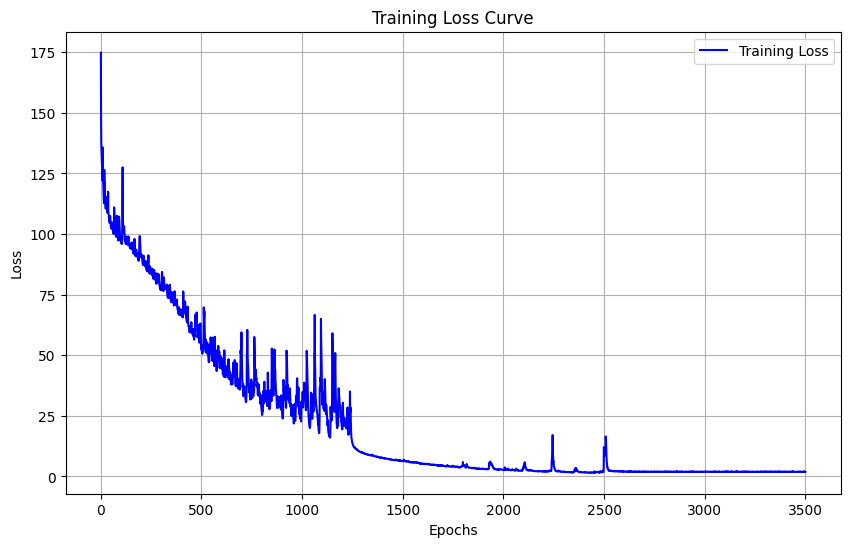

<ipython-input-12-30345ee74e33>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'drive/My Drive/data/checkpoints/{last_checkpoint}_checkp

In [ ]:
import matplotlib.pyplot as plt

if LOAD_FROM_CHECKPOINT:
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
else:
    for epoch in range(1, epochs + 1):
        train_loss = train(epoch)
        scheduler.step(train_loss)

  # After training, plot the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), losses, label='Training Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Get highest numberd checkpoint with this data signature from the checkpoints directory
    checkpoints = os.listdir('drive/My Drive/data/checkpoints')
    checkpoints = [c for c in checkpoints if data_signature in c]
    checkpoints = [c.split('_')[0] for c in checkpoints]
    last_checkpoint = max([int(c) for c in checkpoints])

    model.load_state_dict(torch.load(f'drive/My Drive/data/checkpoints/{last_checkpoint}_checkpoint_{data_signature}.pt', map_location=torch.device('cpu')))


Autodock VINA Work to Predict Binding Affinity, will be used for scoring f

In [ ]:
import contextlib
with open("/content/installation.log", "w") as i:
    with contextlib.redirect_stdout(i):

        # Install core dependencies
        !pip install py3Dmol==2.0.3
        !pip install pybel==0.15.5
        !pip install rdkit-pypi==2022.9.5
        !pip install openbabel==3.1.1

        # Install AutoDock Vina
        !wget https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.0/vina_1.2.0_linux_x86_64 -O vina
        !chmod u+x vina
        !mv vina /usr/local/bin/vina

        # Install other necessary tools
        !pip install plip==2.2.2
        !pip install xlsxwriter==3.0.3

        # Clean up
        !rm -r /content/sample_data /content/condacolab_install.log

#@title **Import Python modules**

import os
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages/')

import ast
import math
#import plip
import timeit
import shutil
import py3Dmol
import contextlib
import xlsxwriter
import urllib.request

import numpy as np
import pandas as pd

from google.colab import drive, files
from tqdm.notebook import tqdm
from openbabel import pybel
#from Bio.PDB import PDBIO, PDBParser
from rdkit import Chem
from rdkit.Chem import rdFMCS, AllChem, PandasTools
#from plip.exchange.report import BindingSiteReport
#from plip.structure.preparation import PDBComplex

print(f"+ Imported done")
print(f"+ Environment ready for molecular docking")

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [40]:
import os
import timeit
import numpy as np
import pandas as pd
import pybel
from tqdm import tqdm
import openbabel
from openbabel import pybel

# Define file paths for dual proteins
CDK5_pdbqt = 'drive/My Drive/data/protein_structures/CDK5.pdbqt'
BACE1_pdbqt = 'drive/My Drive/data/protein_structures/BACE1.pdbqt'

# Define the folder for docking results
DCK_FLD = "drive/My Drive/data/protein_structures"  # Modify this path as needed

# Ensure the directory for docking results exists
if not os.path.exists(DCK_FLD):
    os.makedirs(DCK_FLD)

# Ligand input (just input some test molecules for now, can be part of RL model later)
ligand_smiles = ["CN(C)c1ncnc2c1ncn2CCn1cnc2ncnc(N(C)C)c21", "CCCN(C)C(=O)O", "CC1=CC2=C(C=C1)C(=O)N2", "CCCCCC"]  # Example compounds (SMILES format)
lig_IDs = [f"ligand_{i}" for i in range(len(ligand_smiles))]  # Generating ligand identifiers

# Define AutoDock Vina parameters
Exhaustiveness = 8  # Adjust exhaustiveness as needed
cpu_num = os.cpu_count()
time_elp = N = 0

def get_score(docked_output_file, receptor_pdbqt):
    """Parse the Vina log file to extract binding affinity."""
    log_file = docked_output_file.replace(".pdbqt", "_log.txt")

    # Open and read the log file
    with open(log_file, 'r') as f:
        lines = f.readlines()

    # Look for lines that start with '1' (pose identifier) and extract affinity
    best_affinity = None
    for line in lines:
        if line.startswith('1'):  # Pose number starts with '1'
            # Split the line and extract the binding affinity (typically the second-to-last column)
            columns = line.split()
            affinity = float(columns[-2])  # The binding affinity is in the second to last column
            best_affinity = affinity
            break  # Assuming we are interested in the first pose (most likely the best one)

    if best_affinity is None:
        print(f"Warning: No binding affinity found in {log_file}")
        best_affinity = float('nan')  # If no affinity found, return NaN (or some other value)

    return {'SCORE': best_affinity}

# Start the docking process for each ligand
for N, ID in enumerate(tqdm(lig_IDs)):
    # Convert SMILES to OBMol (OpenBabel molecule) using OpenBabel directly
    obConversion = openbabel.OBConversion()
    obConversion.SetInAndOutFormats("smiles", "pdbqt")
    mol = openbabel.OBMol()
    obConversion.ReadString(mol, ligand_smiles[N])

    # Create a ligand PDBQT file
    ligand_pdbqt_Dfile = os.path.join(DCK_FLD, f"{ID}.pdbqt")
    obConversion.WriteFile(mol, ligand_pdbqt_Dfile)

    # Ensure log directories exist
    cdk5_log_dir = os.path.dirname(os.path.join(DCK_FLD, f"{ID}_CDK5_log.txt"))
    bace1_log_dir = os.path.dirname(os.path.join(DCK_FLD, f"{ID}_BACE1_log.txt"))

    if not os.path.exists(cdk5_log_dir):
        os.makedirs(cdk5_log_dir)

    if not os.path.exists(bace1_log_dir):
        os.makedirs(bace1_log_dir)

    # Continue with the docking process...
    cdk5_output = os.path.join(DCK_FLD, f"{ID}_CDK5_output.pdbqt")
    bace1_output = os.path.join(DCK_FLD, f"{ID}_BACE1_output.pdbqt")

    # Define log file paths for CDK5 and BACE1
    cdk5_log = os.path.join(DCK_FLD, f"{ID}_CDK5_log.txt")
    bace1_log = os.path.join(DCK_FLD, f"{ID}_BACE1_log.txt")

    # Print log paths for debugging
    print(f"Docking output for CDK5 will be saved to: {cdk5_output}")
    print(f"Docking log for CDK5 will be saved to: {cdk5_log}")
    print(f"Docking output for BACE1 will be saved to: {bace1_output}")
    print(f"Docking log for BACE1 will be saved to: {bace1_log}")

    # Run docking for CDK5
    start = timeit.default_timer()
    os.system(f"vina --receptor {CDK5_pdbqt} --ligand {ligand_pdbqt_Dfile} --out {cdk5_output} --log {cdk5_log} --config config.txt --exhaustiveness {Exhaustiveness} --cpu {cpu_num}")
    stop = timeit.default_timer()
    cdk5_runtime = stop - start

    # Run docking for BACE1
    start = timeit.default_timer()
    os.system(f"vina --receptor {BACE1_pdbqt} --ligand {ligand_pdbqt_Dfile} --out {bace1_output} --log {bace1_log} --config config.txt --exhaustiveness {Exhaustiveness} --cpu {cpu_num}")
    stop = timeit.default_timer()
    bace1_runtime = stop - start

    # Print the docking results (binding affinity)
    print(f"Docking completed for {ID}:")
    cdk5_score = get_score(cdk5_output, CDK5_pdbqt)  # Extracted binding affinity
    bace1_score = get_score(bace1_output, BACE1_pdbqt)  # Extracted binding affinity
    print(f"  CDK5 Binding Affinity: {cdk5_score['SCORE']:.3f} kcal/mol")
    print(f"  BACE1 Binding Affinity: {bace1_score['SCORE']:.3f} kcal/mol")
    print(f"  Time taken for CDK5: {cdk5_runtime:.2f}s")
    print(f"  Time taken for BACE1: {bace1_runtime:.2f}s")
    print("-" * 50)

    time_elp += cdk5_runtime + bace1_runtime
    N += 1

# Print total time elapsed
print(f"Total Time Elapsed for Docking: {time_elp:.2f}s")


# Rank and print final results
vina_rank = pd.DataFrame()
for N, ID in enumerate(lig_IDs):
    cdk5_output = os.path.join(DCK_FLD, f"{ID}_CDK5_output.pdbqt")
    bace1_output = os.path.join(DCK_FLD, f"{ID}_BACE1_output.pdbqt")

    # Extract actual binding affinity from log files
    cdk5_score = get_score(cdk5_output, CDK5_pdbqt)
    bace1_score = get_score(bace1_output, BACE1_pdbqt)

    # Create DataFrame for ranking
    vina_rank = pd.concat([vina_rank, pd.DataFrame([{
        'Ligand': ID,
        'CDK5_Score': cdk5_score['SCORE'],
        'BACE1_Score': bace1_score['SCORE']
    }])], ignore_index=True)

# Sort the ligands based on the scores (this can be refined with a more detailed scoring function)
vina_rank = vina_rank.sort_values(by=['CDK5_Score', 'BACE1_Score'], ascending=[True, True], ignore_index=True)

# Print top 10 ranked ligands
print(vina_rank.head(10))

# Save results to CSV
ranked_result_csv = os.path.join(DCK_FLD, "ranked_results.csv")
vina_rank.to_csv(ranked_result_csv, index=False)
print(f"Ranking results saved to {ranked_result_csv}")

  0%|          | 0/4 [00:00<?, ?it/s]

Docking output for CDK5 will be saved to: drive/My Drive/data/protein_structures/ligand_0_CDK5_output.pdbqt
Docking log for CDK5 will be saved to: drive/My Drive/data/protein_structures/ligand_0_CDK5_log.txt
Docking output for BACE1 will be saved to: drive/My Drive/data/protein_structures/ligand_0_BACE1_output.pdbqt
Docking log for BACE1 will be saved to: drive/My Drive/data/protein_structures/ligand_0_BACE1_log.txt
Docking completed for ligand_0:


FileNotFoundError: [Errno 2] No such file or directory: 'drive/My Drive/data/protein_structures/ligand_0_CDK5_output_log.txt'

In [43]:
import os
import timeit
from tqdm import tqdm
import pandas as pd

# Set the paths for receptor files and docking folder
CDK5_pdbqt = 'drive/My Drive/data/protein_structures/CDK5.pdbqt'  # Receptor file for CDK5
BACE1_pdbqt = 'drive/My Drive/data/protein_structures/BACE1.pdbqt' # Receptor file for BACE1
DCK_FLD = "drive/My Drive/data/protein_structures"  # Folder to save the docking results

# Set ligands (provide file paths for ligands or SMILES here)
ligand_files = ['drive/My Drive/data/protein_structures/ligand_0.pdbqt', 'drive/My Drive/data/protein_structures/ligand_1.pdbqt']  # List of ligand PDBQT files

# Define AutoDock Vina parameters
Exhaustiveness = 8
cpu_num = os.cpu_count()

def run_vina_docking(receptor_pdbqt, ligand_pdbqt, output_pdbqt, log_file):
    """Run AutoDock Vina docking and log the results."""
    docking_command = f"vina --receptor {receptor_pdbqt} --ligand {ligand_pdbqt} --out {output_pdbqt} --log {log_file} --exhaustiveness {Exhaustiveness} --cpu {cpu_num}"
    os.system(docking_command)

def extract_binding_affinity(log_file):
    """Extract the binding affinity (Vina energy) from the Vina log file."""
    with open(log_file, 'r') as file:
        lines = file.readlines()

    # Search for the line that contains the 'Vina Energy' (the binding affinity)
    for line in lines:
        if "Vina Energy" in line:
            # Extract the energy value, which is the last word in that line
            energy = line.split()[-1]  # The energy value is usually at the end of the line
            try:
                return float(energy)  # Convert the energy to a float (in kcal/mol)
            except ValueError:
                return None  # Return None if there's no valid energy value found
    return None  # Return None if no energy line is found

# Loop over ligands and run docking for each receptor (CDK5 and BACE1)
for ligand in tqdm(ligand_files):
    ligand_name = os.path.basename(ligand).split('.')[0]  # Extract ligand name
    print(f"Processing {ligand_name}...")

    # Define output and log file paths for CDK5 and BACE1
    cdk5_output = os.path.join(DCK_FLD, f"{ligand_name}_CDK5_output.pdbqt")
    bace1_output = os.path.join(DCK_FLD, f"{ligand_name}_BACE1_output.pdbqt")
    cdk5_log = os.path.join(DCK_FLD, f"{ligand_name}_CDK5_log.txt")
    bace1_log = os.path.join(DCK_FLD, f"{ligand_name}_BACE1_log.txt")

    # Run docking for CDK5
    start = timeit.default_timer()
    run_vina_docking(CDK5_pdbqt, ligand, cdk5_output, cdk5_log)
    stop = timeit.default_timer()
    cdk5_runtime = stop - start
    print(f"CDK5 docking completed for {ligand_name} in {cdk5_runtime:.2f} seconds.")

    # Run docking for BACE1
    start = timeit.default_timer()
    run_vina_docking(BACE1_pdbqt, ligand, bace1_output, bace1_log)
    stop = timeit.default_timer()
    bace1_runtime = stop - start
    print(f"BACE1 docking completed for {ligand_name} in {bace1_runtime:.2f} seconds.")

    # Extract binding affinity for CDK5 and BACE1 from the log files
    cdk5_affinity = extract_binding_affinity(cdk5_log)
    bace1_affinity = extract_binding_affinity(bace1_log)

    # Print binding affinity results
    print(f"Binding Affinity for {ligand_name}:")
    print(f"  CDK5 Binding Affinity: {cdk5_affinity if cdk5_affinity is not None else 'Not Found'} kcal/mol")
    print(f"  BACE1 Binding Affinity: {bace1_affinity if bace1_affinity is not None else 'Not Found'} kcal/mol")
    print("-" * 50)

# Optional: You can collect the binding affinities in a DataFrame or CSV for further analysis
# Example: Save binding affinities to CSV
binding_data = []

# Collect binding affinities for each ligand
for ligand in ligand_files:
    ligand_name = os.path.basename(ligand).split('.')[0]
    cdk5_log = os.path.join(DCK_FLD, f"{ligand_name}_CDK5_log.txt")
    bace1_log = os.path.join(DCK_FLD, f"{ligand_name}_BACE1_log.txt")

    cdk5_affinity = extract_binding_affinity(cdk5_log)
    bace1_affinity = extract_binding_affinity(bace1_log)

    binding_data.append({
        'Ligand': ligand_name,
        'CDK5 Binding Affinity (kcal/mol)': cdk5_affinity if cdk5_affinity is not None else 'Not Found',
        'BACE1 Binding Affinity (kcal/mol)': bace1_affinity if bace1_affinity is not None else 'Not Found'
    })

# Create a DataFrame and save to CSV
binding_df = pd.DataFrame(binding_data)
binding_df.to_csv(os.path.join(DCK_FLD, "binding_affinities.csv"), index=False)

print("Binding affinities saved to 'binding_affinities.csv'.")



100%|██████████| 2/2 [00:00<00:00, 28.23it/s]

Processing ligand_0...
CDK5 docking completed for ligand_0 in 0.02 seconds.
BACE1 docking completed for ligand_0 in 0.01 seconds.
Binding Affinity for ligand_0:
  CDK5 Binding Affinity: Not Found kcal/mol
  BACE1 Binding Affinity: Not Found kcal/mol
--------------------------------------------------
Processing ligand_1...
CDK5 docking completed for ligand_1 in 0.02 seconds.
BACE1 docking completed for ligand_1 in 0.01 seconds.
Binding Affinity for ligand_1:
  CDK5 Binding Affinity: Not Found kcal/mol
  BACE1 Binding Affinity: Not Found kcal/mol
--------------------------------------------------
Binding affinities saved to 'binding_affinities.csv'.


In [44]:
import os
import timeit
from tqdm import tqdm
import pandas as pd

# Set the paths for receptor files and docking folder
CDK5_pdb = 'drive/My Drive/data/protein_structures/CDK5.pdb'  # Original receptor PDB file
BACE1_pdb = 'drive/My Drive/data/protein_structures/BACE1.pdb' # Original receptor PDB file
DCK_FLD = "drive/My Drive/data/protein_structures"  # Folder to save the docking results

# Set ligands (provide file paths for ligands or SMILES here)
ligand_files = ['drive/My Drive/data/protein_structures/ligand_0.pdb', 'drive/My Drive/data/protein_structures/ligand_1.pdb']  # List of ligand PDB files

# Define AutoDock Vina parameters
Exhaustiveness = 8
cpu_num = os.cpu_count()

# Prepare receptor and ligand by converting to PDBQT format and adding hydrogens
def add_hydrogens(input_pdb, output_pdbqt):
    """Add hydrogens to a PDB file and convert it to PDBQT."""
    command = f"obabel {input_pdb} -O {output_pdbqt} --addhydrogens"
    os.system(command)

def prepare_receptor(input_pdb, output_pdbqt):
    """Prepare the receptor by converting it to PDBQT format and adding hydrogens."""
    add_hydrogens(input_pdb, output_pdbqt)

def prepare_ligand(input_pdb, output_pdbqt):
    """Prepare the ligand by converting it to PDBQT format and adding hydrogens."""
    add_hydrogens(input_pdb, output_pdbqt)

# Convert and prepare the receptors and ligands
prepare_receptor(CDK5_pdb, 'drive/My Drive/data/protein_structures/CDK5.pdbqt')
prepare_receptor(BACE1_pdb, 'drive/My Drive/data/protein_structures/BACE1.pdbqt')

# Convert ligands
for ligand in ligand_files:
    ligand_name = os.path.basename(ligand).split('.')[0]  # Extract ligand name
    prepare_ligand(ligand, f'drive/My Drive/data/protein_structures/{ligand_name}.pdbqt')

# Define docking function and affinity extraction (as before)
def run_vina_docking(receptor_pdbqt, ligand_pdbqt, output_pdbqt, log_file):
    """Run AutoDock Vina docking and log the results."""
    docking_command = f"vina --receptor {receptor_pdbqt} --ligand {ligand_pdbqt} --out {output_pdbqt} --log {log_file} --exhaustiveness {Exhaustiveness} --cpu {cpu_num}"
    os.system(docking_command)

def extract_binding_affinity(log_file):
    """Extract the binding affinity (Vina energy) from the Vina log file."""
    with open(log_file, 'r') as file:
        lines = file.readlines()

    for line in lines:
        if "Vina Energy" in line:
            energy = line.split()[-1]
            try:
                return float(energy)
            except ValueError:
                return None
    return None

# Run docking for each ligand and receptor
for ligand in tqdm(ligand_files):
    ligand_name = os.path.basename(ligand).split('.')[0]
    print(f"Processing {ligand_name}...")

    cdk5_output = os.path.join(DCK_FLD, f"{ligand_name}_CDK5_output.pdbqt")
    bace1_output = os.path.join(DCK_FLD, f"{ligand_name}_BACE1_output.pdbqt")
    cdk5_log = os.path.join(DCK_FLD, f"{ligand_name}_CDK5_log.txt")
    bace1_log = os.path.join(DCK_FLD, f"{ligand_name}_BACE1_log.txt")

    # Run docking for CDK5
    start = timeit.default_timer()
    run_vina_docking('drive/My Drive/data/protein_structures/CDK5.pdbqt', ligand, cdk5_output, cdk5_log)
    stop = timeit.default_timer()
    cdk5_runtime = stop - start
    print(f"CDK5 docking completed for {ligand_name} in {cdk5_runtime:.2f} seconds.")

    # Run docking for BACE1
    start = timeit.default_timer()
    run_vina_docking('drive/My Drive/data/protein_structures/BACE1.pdbqt', ligand, bace1_output, bace1_log)
    stop = timeit.default_timer()
    bace1_runtime = stop - start
    print(f"BACE1 docking completed for {ligand_name} in {bace1_runtime:.2f} seconds.")

    # Extract binding affinity for CDK5 and BACE1
    cdk5_affinity = extract_binding_affinity(cdk5_log)
    bace1_affinity = extract_binding_affinity(bace1_log)

    print(f"Binding Affinity for {ligand_name}:")
    print(f"  CDK5 Binding Affinity: {cdk5_affinity if cdk5_affinity else 'Not Found'} kcal/mol")
    print(f"  BACE1 Binding Affinity: {bace1_affinity if bace1_affinity else 'Not Found'} kcal/mol")
    print("-" * 50)

# Save the binding affinities to a CSV
binding_data = []
for ligand in ligand_files:
    ligand_name = os.path.basename(ligand).split('.')[0]
    cdk5_log = os.path.join(DCK_FLD, f"{ligand_name}_CDK5_log.txt")
    bace1_log = os.path.join(DCK_FLD, f"{ligand_name}_BACE1_log.txt")

    cdk5_affinity = extract_binding_affinity(cdk5_log)
    bace1_affinity = extract_binding_affinity(bace1_log)

    binding_data.append({
        'Ligand': ligand_name,
        'CDK5 Binding Affinity (kcal/mol)': cdk5_affinity if cdk5_affinity else 'Not Found',
        'BACE1 Binding Affinity (kcal/mol)': bace1_affinity if bace1_affinity else 'Not Found'
    })

# Create DataFrame and save to CSV
binding_df = pd.DataFrame(binding_data)
binding_df.to_csv(os.path.join(DCK_FLD, "binding_affinities.csv"), index=False)

print("Binding affinities saved to 'binding_affinities.csv'.")


100%|██████████| 2/2 [00:00<00:00, 30.49it/s]

Processing ligand_0...
CDK5 docking completed for ligand_0 in 0.01 seconds.
BACE1 docking completed for ligand_0 in 0.01 seconds.
Binding Affinity for ligand_0:
  CDK5 Binding Affinity: Not Found kcal/mol
  BACE1 Binding Affinity: Not Found kcal/mol
--------------------------------------------------
Processing ligand_1...
CDK5 docking completed for ligand_1 in 0.02 seconds.
BACE1 docking completed for ligand_1 in 0.02 seconds.
Binding Affinity for ligand_1:
  CDK5 Binding Affinity: Not Found kcal/mol
  BACE1 Binding Affinity: Not Found kcal/mol
--------------------------------------------------
Binding affinities saved to 'binding_affinities.csv'.


In [66]:
# @title (1) Install Condacolab (< 1min)
%%time

! pip install -q condacolab
import condacolab
condacolab.install()

#@markdown > An automatic restart of the kernel is expected after the execution of this block.
#@markdown >
#@markdown > Stay connected to the same runtime and proceed to the next code block!

✨🍰✨ Everything looks OK!
CPU times: user 13.3 ms, sys: 901 µs, total: 14.2 ms
Wall time: 810 ms


In [67]:
# @title (2) Install Packages and Data (~ 2min)
%%time

# Get environment configuration from Git Repository
setup_repo="https://github.com/rwxayheee/colab_setup"
!git clone {setup_repo}

# Run setup script
!chmod +x colab_setup/basic_setup.sh
!bash colab_setup/basic_setup.sh

fatal: destination path 'colab_setup' already exists and is not an empty directory.

[INFO] Step 1: Installing Python packages using Conda and Pip...

colab_setup/basic_setup.sh: /usr/local/bin/conda: /usr/local/bin/python: bad interpreter: No such file or directory

[ERROR] Failed to install Python packages. Ensure Conda is installed and the YAML file exists.

CPU times: user 17.7 ms, sys: 44 µs, total: 17.8 ms
Wall time: 359 ms


In [ ]:
!pip install cytoolz

In [ ]:
!pip install scrub

In [2]:
# @title (3) Import Modules & Install Required Packages (~ 1min)
%%time

# Install required packages for Colab environment
!pip install prody rdkit py3Dmol ipywidgets

# Install Conda for handling dependencies if necessary (in case we need other non-pip packages)
!pip install conda

# Command line tools and additional dependencies
!apt-get install -y python3-pyqt5  # For py3Dmol dependency
!apt-get install -y build-essential python3-dev  # Build tools

# Install 'scrub' using pip or from GitHub
!pip install scrub  # If available on pip
# If not, let's clone and install from GitHub
try:
    !pip install scrub
except:
    print("Scrub package not found on pip. Cloning from GitHub...")
    !git clone https://github.com/rwxayheee/scrub.git
    %cd scrub
    !python3 setup.py install
    %cd ..

# Installing other tools directly from GitHub if necessary
!git clone https://github.com/rwxayheee/colab_setup  # Clone if it's not already present
%cd colab_setup
!chmod +x basic_setup.sh
!bash basic_setup.sh
%cd ..

# Import modules after installation
import sys, platform
from prody import *
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit, py3Dmol
print("rdkit version:", rdkit.__version__)
print("py3Dmol version:", py3Dmol.__version__)
from ipywidgets import interact, IntSlider
import ipywidgets, copy
from IPython.display import display, Markdown

# Helper function to locate files
def locate_file(from_path=None, query_path=None, query_name="query file"):
    if not from_path or not query_path:
        raise ValueError("Must specify from_path and query_path")

    possible_path = list(from_path.glob(query_path))

    if not possible_path:
        raise FileNotFoundError(f"Cannot find {query_name} from {from_path} by {query_path}")

    return_which = (
        f"using {query_name} at:\n"
        f"{possible_path[0]}\n"
    )
    print(return_which)

    return possible_path[0]


# Command-line tools
scrub = locate_file(from_path=Path("/usr/local/bin"), query_path="scrub.py", query_name="scrub.py")
mk_prepare_ligand = locate_file(from_path=Path("/usr/local/bin"), query_path="mk_prepare_ligand.py", query_name="mk_prepare_ligand.py")
mk_prepare_receptor = locate_file(from_path=Path("/usr/local/bin"), query_path="mk_prepare_receptor.py", query_name="mk_prepare_receptor.py")
mk_export = locate_file(from_path=Path("/usr/local/bin"), query_path="mk_export.py", query_name="mk_export.py")

# Locate reduce2 in Conda install prefix
full_py_version = platform.python_version()
major_and_minor = ".".join(full_py_version.split(".")[:2])
env_path = Path("/usr/local")  # Default Conda install prefix on Colab
reduce2_path = f"lib/python{major_and_minor}/site-packages/mmtbx/command_line/reduce2.py"
reduce2 = locate_file(from_path=env_path, query_path=reduce2_path, query_name="reduce2.py")

# Locate geostd in current path
geostd_path = locate_file(from_path=Path.cwd(), query_path="geostd", query_name="geostd")

# Version of imported modules and locations of command-line scripts will be reported to output.


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5designer5 libqt5gui5 libqt5help5 libqt5network5 libqt5printsupport5 libqt5sql5
  libqt5sql5-sqlite libqt5svg5 libqt5test5 libqt5widgets5 libqt5xml5 libwacom-bin libwacom-common
  libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1 libxcb-render-util0 libxcb-util1
  libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0 python3-pyqt5.sip
  qt5-gtk-platformtheme qttranslations5-l10n
Suggested packages:
  qt5-image-formats-plugins qtwayland5
The following NEW packages will be installed:
  libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5designer5 libqt5gui5 libqt5help5 libqt5network5 libqt5printsupport5 libqt5sql5
  libqt5sql5-sqlite libqt5svg5 libqt5test5 libqt5widgets5 libqt5xm

FileNotFoundError: Cannot find scrub.py from /usr/local/bin by scrub.py

In [73]:
# @title # 1.1 Ligand Preparation (< 5s)
# @markdown In this step, the ligand molecule is prepared from a Smiles string. A protonated 3D conformer of ligand is generated by **scrub.py**, and the conversion to a tangible ligand PDBQT file is done by **mk_prepare_ligand.py**.
%%time

# @markdown > Enter the Smiles string of ligand. This will be used as input for ***molscrub*** to protonate and generate a 3D conformer of the ligand.
ligand_Smiles = "CN(C)c1ncnc2c1ncn2CCn1cnc2ncnc(N(C)C)c21" #@param {type:"string"}

# @markdown > Below are some available options of ***molscrub*** to determine what protonation variants to be generated for the input ligand.

# @markdown > A designated pH is required.
pH = 6 #@param {type:"raw"}
# @markdown > The following two options allow you to opt out from enumeration of tautomers or protomers.
# @markdown > In this the example, we will ask ***molscrub*** to perform acidbase enumeration only for the ligand.
args = ""
skip_tautomer = True #@param {type:"boolean"}
if skip_tautomer:
  args += "--skip_tautomer "
skip_acidbase = False #@param {type:"boolean"}
if skip_acidbase:
  args += "--skip_acidbase "
# @markdown With the above specifications, a 3D conformer of the protonated ligand will be generated by **scrub.py**.
# @markdown
# @markdown The SDF file is then fed to **mk_prepare_ligand.py** to generate the ligand PDBQT file.

# @markdown > A name for the ligand PDBQT file is required.
ligandPDBQT = "STI.pdbqt" #@param {type:"string"}


# Write scrubbed protomer(s) and conformer(s) to SDF
ligandName = ligandPDBQT.replace(".pdbqt", "")
ligandSDF = f"{ligandName}_scrubbed.sdf"
! python {scrub} "{ligand_Smiles}" -o {ligandSDF} --ph {pH} {args}


# Prepare ligand PDBQT
! python {mk_prepare_ligand} -i {ligandSDF} -o {ligandPDBQT}


# Visualization with py3Dmol
view = py3Dmol.view()
view.addModel(open(ligandSDF, 'r').read(),'sdf')
view.zoomTo()
view.setBackgroundColor('white')
view.addStyle({'stick': {'colorscheme':'yellowCarbon'}})
view.show()

/bin/bash: line 1: python: command not found
/bin/bash: line 1: python: command not found


FileNotFoundError: [Errno 2] No such file or directory: 'STI_scrubbed.sdf'

In [ ]:
# @title # 1.2 Receptor Preparation (< 30s)
%%time
#@markdown The preparation of a rigid receptor consists of two steps. The receptor structure is first sourced from a PDB file and sent to **reduce2.py** for hydrogen addition and optimization, and then, the conversion to a tangible receptor PDBQT file is done by **mk_prepare_receptor.py**.

#@markdown ## (1) Add Hydrogens to Receptor with Reduce2

# @markdown > Enter the PDB ID here to source the starting structure of receptor. This PDB file will be pulled from RCSB PDB server.
# Download PDB file
pdb_token = "1iep" #@param {type:"string"}
! curl "http://files.rcsb.org/view/{pdb_token}.pdb" -o "{pdb_token}.pdb"


# Export receptor atoms
atoms_from_pdb = parsePDB(pdb_token)
# @markdown > Use ProDy selection language to specify atoms to retain in receptor.
receptor_selection = "chain A and not water and not hetero" #@param {type:"string"}
receptor_atoms = atoms_from_pdb.select(receptor_selection)
prody_receptorPDB = f"{pdb_token}_receptor_atoms.pdb"
writePDB(prody_receptorPDB, receptor_atoms)


# Add CRYST1 card (temporarily required for reduce2)
reduce_inputPDB = f"{pdb_token}_receptor.pdb"
! cat <(grep "CRYST1" "{pdb_token}.pdb") {prody_receptorPDB} > {reduce_inputPDB}


# Run reduce2
# @markdown > Use PHIL arguments to specify the tasks for reduce2. In this example, we use `approach=add add_flip_movers=True` which is equivalent to `-build` or `-flip` in the formerly standalone reduce. These arguments ask ***reduce*** to allow NQH flips and build histidines to neutral tautomers while adding hydrogens.
reduce_opts = "approach=add add_flip_movers=True" #@param {type:"string"}
! export MMTBX_CCP4_MONOMER_LIB="{geostd_path}"; python {reduce2} {reduce_inputPDB} {reduce_opts}
# Default name of reduce output...
prepare_inPDB = f"{pdb_token}_receptorFH.pdb"

#@markdown ---
#@markdown ## (2) Receptor Preparation with Meeko

# Specify Box
# Center at ligand
atoms_from_pdb = parsePDB(pdb_token)
#@markdown > Use ProDy selection language to specify (ligand, residue, or any) atoms for box center calculation. In this example, we choose the ligand and will use the geometric center of ligand as box center.
ligand_selection = "chain A and resname STI" #@param {type:"string"}
ligand_atoms = atoms_from_pdb.select(ligand_selection)
center_x, center_y, center_z = calcCenter(ligand_atoms)


#@markdown > Export ligand's original position to a PDB file. This is totally optional, but we will do it for visualization.
prody_ligandPDB = "LIG.pdb" #@param {type:"string"}
writePDB(prody_ligandPDB, ligand_atoms)


# Size in each dimension
#@markdown > Enter the box size (Å) of box in each dimension
size_x = 20.0 #@param {type:"raw"}
size_y = 20.0 #@param {type:"raw"}
size_z = 20.0 #@param {type:"raw"}


# @markdown With the above specifications, atom selection will be made on the original PDB file in ***ProDy***. Then, a protonated structure is generated by **reduce2.py**.
# @markdown
# @markdown The PDB file is then fed to **mk_prepare_receptor.py** to generate the receptor PDBQT file.

# Prepare Receptor
# @markdown > A basename for the receptor PDBQT file is required.
prepare_output = "1iep_receptorFH" #@param {type:"string"}
! python {mk_prepare_receptor} -i {prepare_inPDB} -o {prepare_output} -p -v --box_center {center_x} {center_y} {center_z} --box_size {size_x} {size_y} {size_z}


# Visualization with py3Dmol
def Receptor3DView(receptorPDB = None, boxPDB = None, ligPDB = None):

    view = py3Dmol.view()
    view.setBackgroundColor('white')

    view.addModel(open(boxPDB, 'r').read(),'pdb')
    view.addStyle({'stick': {}})
    view.zoomTo()

    view.addModel(open(receptorPDB, 'r').read(),'pdb')
    view.addStyle({'cartoon': {'color':'spectrum', 'opacity': 0.5}})

    if ligPDB is not None:
      view.addModel(open(ligPDB, 'r').read(), 'pdb')
      view.addStyle({'hetflag': True}, {'stick': {}})

    return view

Receptor3DView(receptorPDB = prepare_inPDB, \
               boxPDB = prepare_output+'.box.pdb', \
               ligPDB = prody_ligandPDB).show()

In [ ]:
# @title # 2. Docking with Vina Scoring Function (~ 3min)
%%time
#@markdown In this step, the docking calculation is executed by ***Vina***.

#@markdown > Specify the names of inputs. You may include any additional options in `configTXT`.
receptorPDBQT = "1iep_receptorFH.pdbqt" #@param {type:"string"}
ligandPDBQT = "STI.pdbqt" #@param {type:"string"}
configTXT = "1iep_receptorFH.box.txt" #@param {type:"string"}
#@markdown > Specify the exhaustiveness of docking. In this example, we use a relatively low `exhaustiveness = 8` for demonstration purposes.
exhaustiveness = 8 #@param {type:"raw"}
#@markdown > A name for the docking output PDBQT file is required.
outputPDBQT = "1iep_STI_vina_out.pdbqt" #@param {type:"string"}

! vina --receptor {receptorPDBQT} --ligand {ligandPDBQT} --config {configTXT} \
       --exhaustiveness {exhaustiveness} \
       --out {outputPDBQT}

In [ ]:
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from IPython.display import display
import rdkit.Chem.QED as QED
from rdkit.Chem import RDConfig
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

CALCULATE METRICS AND SHOW RANDOMIZED SAMPLED MOLECULES FROM LATENT SPACE

In [ ]:
def calculate_mol_metrics(smiles):
    #predict metrics and molweight
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    valid = [1 if m else 0 for m in mols]
    print(f'Num valid: {sum(valid)}')
    frac_valid = sum(valid) / len(valid)
    mol_wt = [Descriptors.MolWt(m) for m in mols if m]
    avg_mol_wt = sum(mol_wt) / len(mol_wt)

    #predict logP
    logP = [Descriptors.MolLogP(m) for m in mols if m]
    avg_logP = sum(logP) / len(logP)

    #predict QED
    qed_score = [QED.qed(m) for m in mols if m]
    avg_qed = sum(qed_score) / len(qed_score)

    #predict synthetic accesibility score
    sas = [sascorer.calculateScore(m) for m in mols if m]
    avg_sas = sum(sas) / len(sas)

    #predict labute asa score
    labute_asa = [Descriptors.LabuteASA(m) for m in mols if m]
    avg_labute_asa = sum(labute_asa) / len(labute_asa)

    #predict lipinski rule of 5
    lipinski_count = 0

    for m in mols:
        if m:  # Check if molecule is valid
            # Extract the metrics for each molecule
            MW = Descriptors.MolWt(m)
            HBA = Descriptors.NOCount(m)
            HBD = Descriptors.NHOHCount(m)
            LogP = Descriptors.MolLogP(m)

            # Check if the molecule passes Lipinski's Rule of 5 conditions
            conditions = [
                MW <= 500,
                HBA <= 10,
                HBD <= 5,
                LogP <= 5
            ]
            # Count the number of conditions the molecule passes
            if conditions.count(True) >= 3:
                lipinski_count += 1

    return frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count

In [ ]:
def test_data (data_test):
    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)
    output, _, _ = model(data_test)

    # Decode the output
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # print the first 10 decoded SMILES and the test data
    for i in range(10):
        print(decoded[i])
        print(decode_smiles_from_indexes(map(from_one_hot_array, data_test[i].cpu().numpy()), charset))
        print()

    # calculate performance metrics
    rdBase.DisableLog('rdApp.*')

    frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count = calculate_mol_metrics(decoded)
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')
    print(f'Average logP score: {avg_logP}')
    print(f'Average QED score: {avg_qed}')
    print(f'Average Synthetic Accessibility Score: {avg_sas}')
    print(f'Average Labute ASA score: {avg_labute_asa}')
    print(f'Total Lipinski Rule of 5 Passings: {lipinski_count}')

    # Draw the first 10 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
    print([d for d in decoded if Chem.MolFromSmiles(d)])
    dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
    display(dr_mol)

CN(CC)c1ccc(-c2cc2c22222c22ccc(C))c2))C1
CN(C)c1ncnc2c1ncn2CCn1cnc2ncnc(N(C)C)c21

CCCNCC(C2c1ccCCCCCCC1C22
CC1OC2(CS1)CN1CCC2CC1.Cl.O

CCCC(C)CC2CC(OCCCC()C(=NCC(N)=C
CCOC(=O)CC/N=C(\N)N=C(N)N.Cl.Cl

C[C@N(CNNCCCCCc2ccc3c3ccc22)CCC3
CN1CC=C(C=Cc2c[nH]c3ccccc23)CC1

CCCCCCCCCCCCC@@H](OC[C[@@HH]O)[C@H](C)N
CCCCCCCCCCCCC[C@@H](O)C[C@@H](O)[C@H](C)N

COc1ccc2c(NN)cccccc(()cccO)c22cc1
COc1ccc2nc(NC(=O)Nc3ccccc3)sc2c1

C1CCC2(CC11OCCC(CCCCCC)OO2
C1CCC2(CC1)COC1(CCCCC1)OC2

O=C(CN1CCN(C(=O)c2ccco2)CC1)Nc1ccccc1Br
O=C(CN1CCN(C(=O)c2ccco2)CC1)Nc1ccccc1Br

O=C(NC(=O)c2cc(CC3CCCCCCccccc21
O=C(/C=C\Nc1ccccn1)c1ccc(Cl)cc1

Cl(=N=CO=C(=O)c1ccc(Cl)cc1C
CN(C)C(=O)CCNc1ccc(Br)cc1

Num valid: 41
Fraction of valid molecules: 0.12654320987654322
Average molecular weight: 238.55153658536585
Average logP score: 2.755546097560977
Average QED score: 0.5826645868539789
Average Synthetic Accessibility Score: 2.4518149458651135
Average Labute ASA score: 99.7153985415076
Total Lipinski Rule of 5 Passings: 41
['O

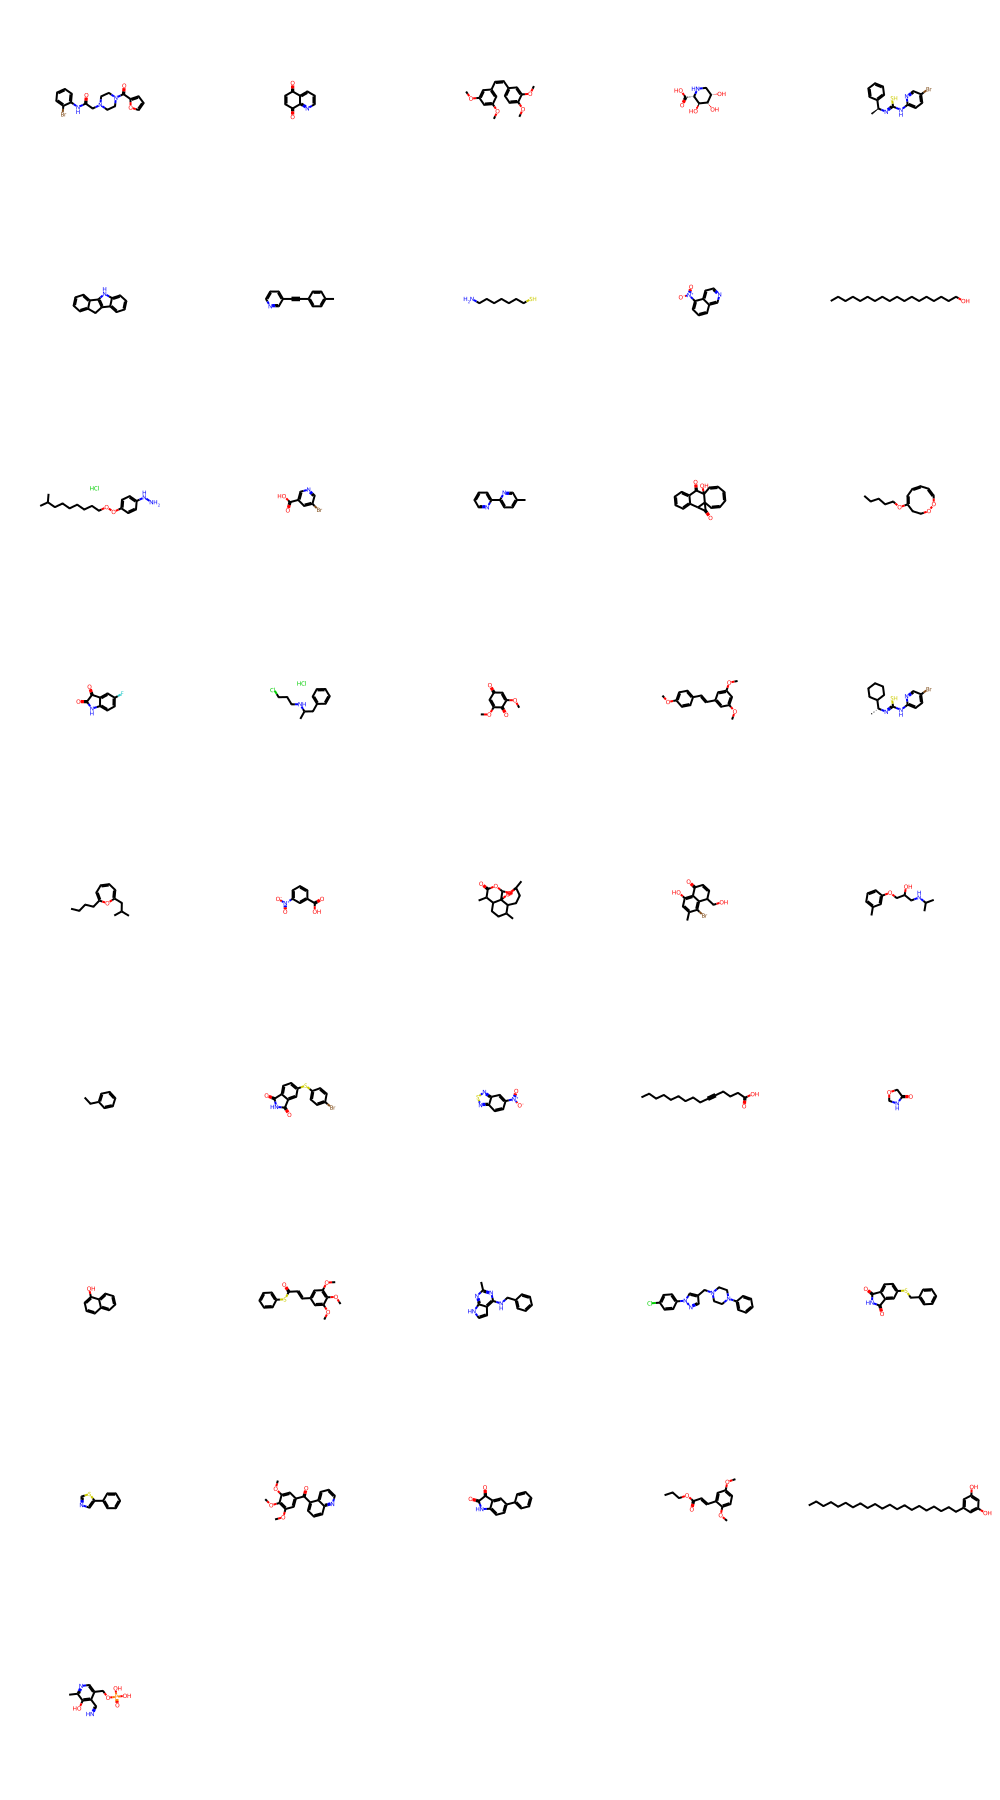

In [ ]:
if RUN_ON_TEST_DATA:
    test_data(data_test)

PLOTTING PROPERTIES (GRAPH OF ALL AND INDIVIDUAL ONES)

Num valid: 35
Fraction of valid molecules: 0.10802469135802469
Average molecular weight: 242.25382857142858
Average logP score: 2.269521142857145
Average QED score: 0.5359237329943173
Average Synthetic Accessibility Score: 2.534014641190682
Average Labute ASA score: 96.43484599399692
Total Lipinski Rule of 5 Passings: 35


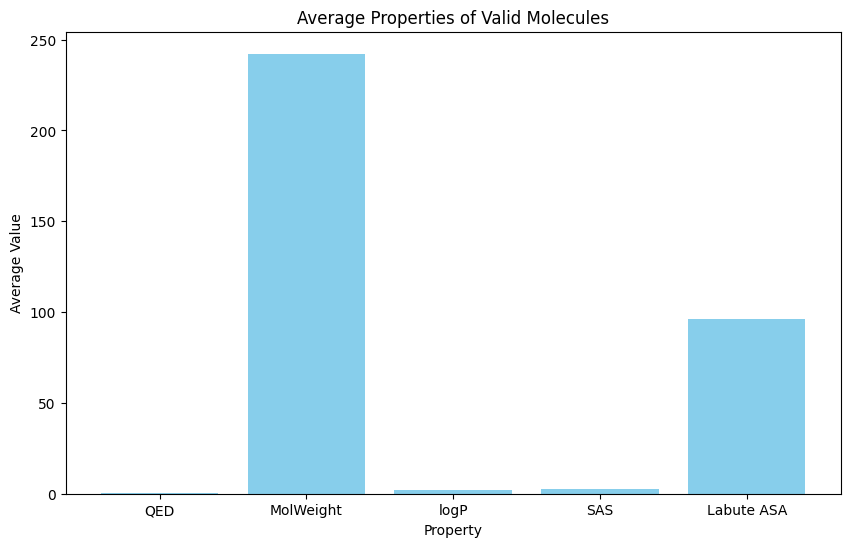

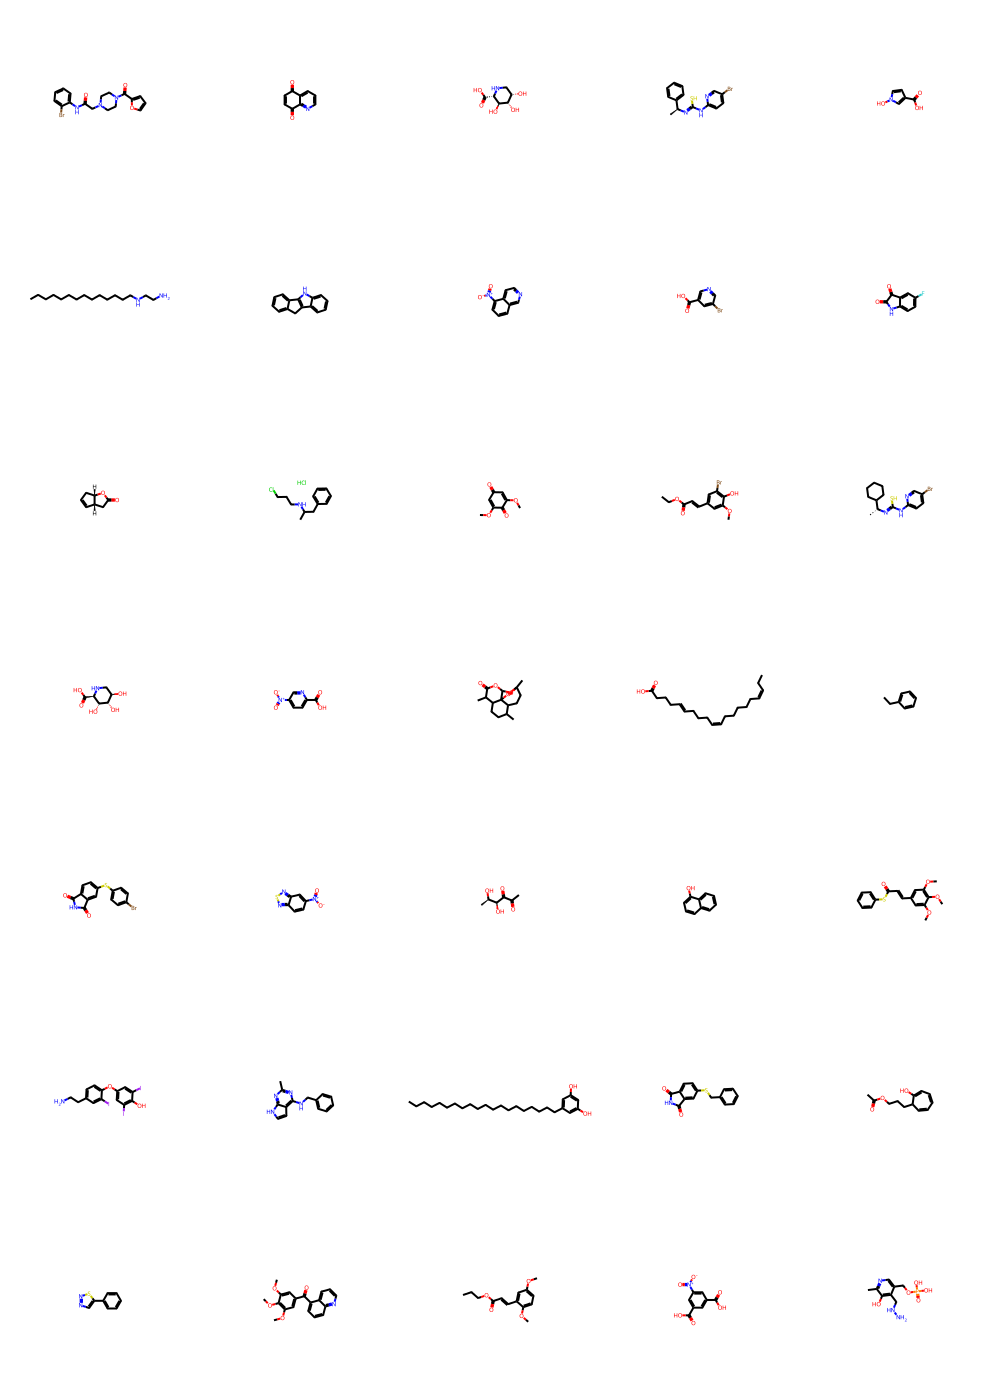

In [ ]:
def test_data(data_test):
    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)
    output, _, _ = model(data_test)

    # Decode the output
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # calculate performance metrics
    rdBase.DisableLog('rdApp.*')
    frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count = calculate_mol_metrics(decoded)

    # Print property metrics
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')
    print(f'Average logP score: {avg_logP}')
    print(f'Average QED score: {avg_qed}')
    print(f'Average Synthetic Accessibility Score: {avg_sas}')
    print(f'Average Labute ASA score: {avg_labute_asa}')
    print(f'Total Lipinski Rule of 5 Passings: {lipinski_count}')

    # Bar Graph for properties
    properties = ['QED', 'MolWeight', 'logP', 'SAS', 'Labute ASA']
    values = [avg_qed, avg_mol_wt, avg_logP, avg_sas, avg_labute_asa]

    plt.figure(figsize=(10, 6))
    plt.bar(properties, values, color='skyblue')
    plt.xlabel('Property')
    plt.ylabel('Average Value')
    plt.title('Average Properties of Valid Molecules')
    plt.show()

    # Draw the first 10 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
    dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
    display(dr_mol)

# Example of running the test
if RUN_ON_TEST_DATA:
    test_data(data_test)

Num valid: 35
Fraction of valid molecules: 0.10802469135802469
Average molecular weight: 236.1910285714286
Average logP score: 2.538281714285717
Average QED score: 0.5101374816380714
Average Synthetic Accessibility Score: 2.5200716698632526
Average Labute ASA score: 99.13240446195312
Total Lipinski Rule of 5 Passings: 35


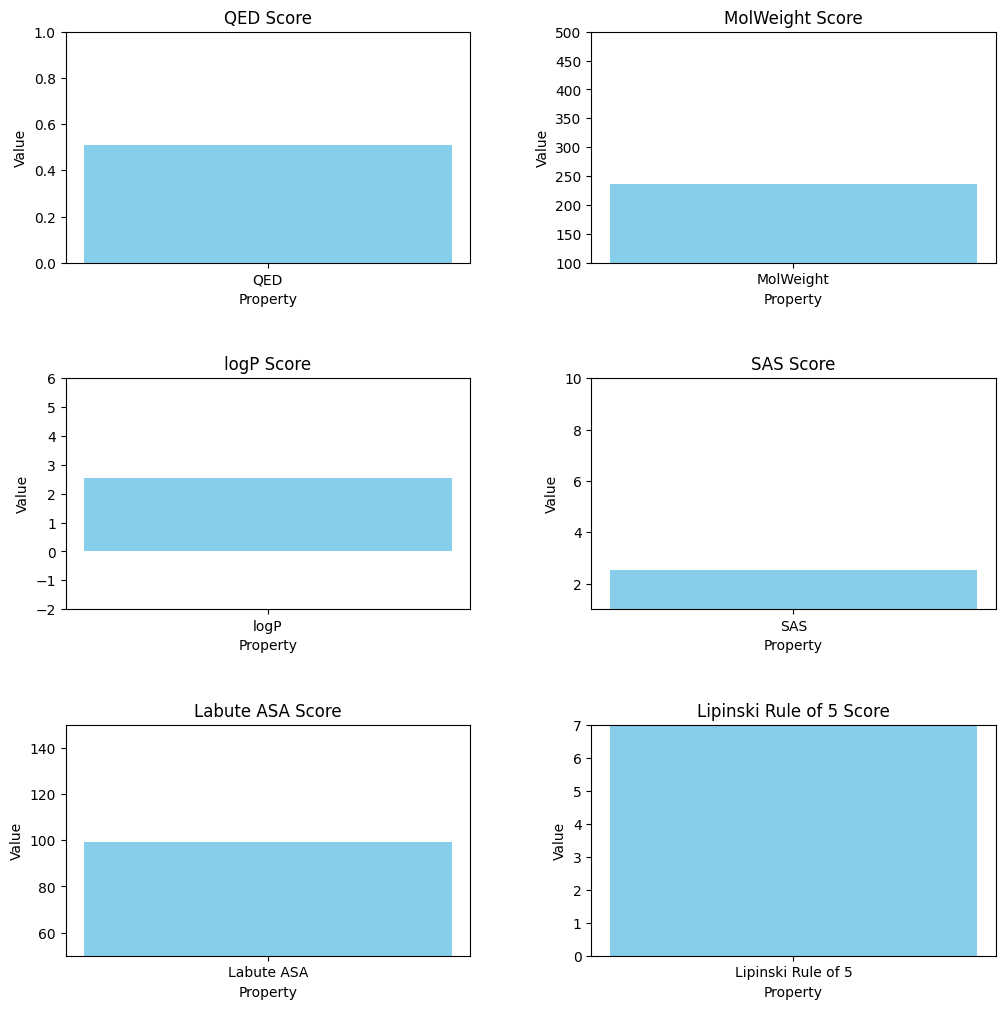

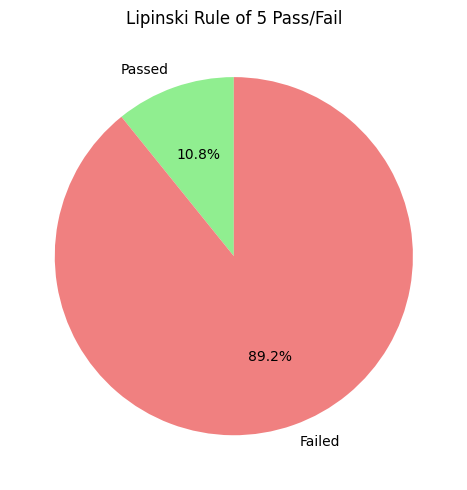

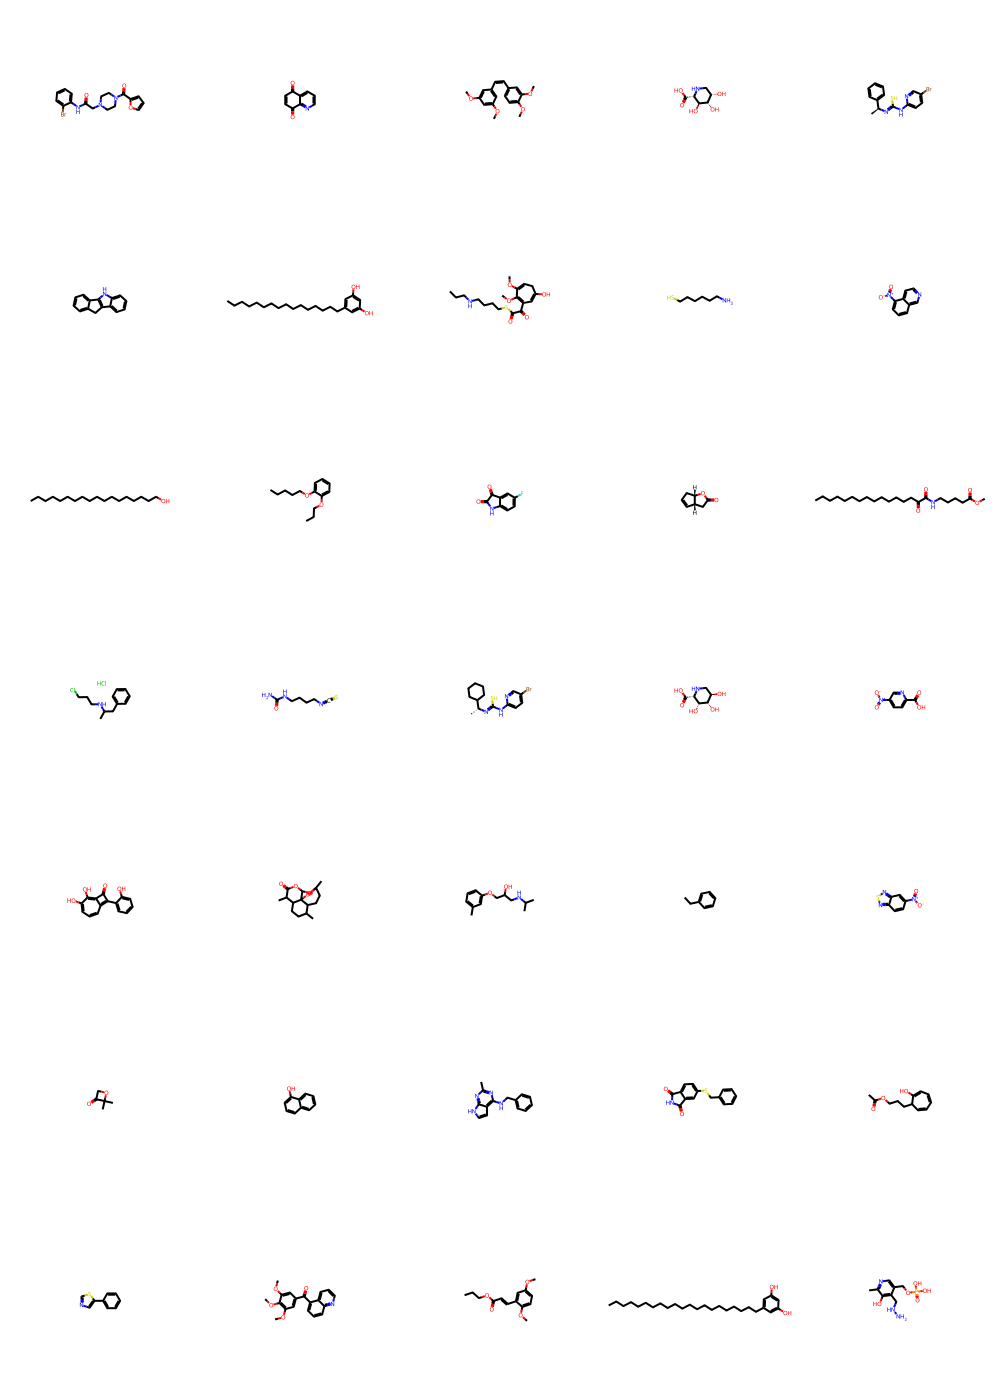

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import torch

def test_data(data_test):
    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)
    output, _, _ = model(data_test)

    # Decode the output
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # Calculate performance metrics
    rdBase.DisableLog('rdApp.*')
    frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count = calculate_mol_metrics(decoded)

    # Print property metrics
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')
    print(f'Average logP score: {avg_logP}')
    print(f'Average QED score: {avg_qed}')
    print(f'Average Synthetic Accessibility Score: {avg_sas}')
    print(f'Average Labute ASA score: {avg_labute_asa}')
    print(f'Total Lipinski Rule of 5 Passings: {lipinski_count}')

    # Properties and values for graphing
    properties = ['QED', 'MolWeight', 'logP', 'SAS', 'Labute ASA', 'Lipinski Rule of 5']
    values = [avg_qed, avg_mol_wt, avg_logP, avg_sas, avg_labute_asa, lipinski_count]

    # Plot each property in a separate graph
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    axs = axs.ravel()  # Flatten the array of axes for easy iteration

    # Bar Graphs for Each Property
    for i, (prop, val) in enumerate(zip(properties, values)):
        axs[i].bar(prop, val, color='skyblue')
        axs[i].set_title(f'{prop} Score')
        axs[i].set_ylabel('Value')
        axs[i].set_xlabel('Property')

        # Dynamically adjust the y-axis limit for each property based on its value range
        y_max = max(values)
        if prop == 'QED':
            axs[i].set_ylim(0, 1)  # QED is typically between 0 and 1
        elif prop == 'MolWeight':
            axs[i].set_ylim(100, 500)  # Molecular weight typically between 100 and 500
        elif prop == 'logP':
            axs[i].set_ylim(-2, 6)  # logP is typically in this range
        elif prop == 'SAS':
            axs[i].set_ylim(1, 10)  # SAS score typically between 1 and 10
        elif prop == 'Labute ASA':
            axs[i].set_ylim(50, 150)  # Labute ASA typically falls in this range
        elif prop == 'Lipinski Rule of 5':
            axs[i].set_ylim(0, 7)  # Lipinski count usually ranges from 0 to 5
# Add more space between the subplots using plt.subplots_adjust()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust vertical and horizontal spacing
    # Create Lipinski Pie Chart
    passed = lipinski_count  # Number of molecules passing Lipinski's Rule
    total = len(decoded)  # Total number of molecules sampled
    failed = total - passed  # Molecules that fail Lipinski's Rule

    # Create a pie chart showing the proportions of pass/fail for Lipinski Rule of 5
    fig_pie, ax_pie = plt.subplots(figsize=(5, 5))
    ax_pie.pie([passed, failed], labels=['Passed', 'Failed'], autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
    ax_pie.set_title('Lipinski Rule of 5 Pass/Fail')

    plt.tight_layout()
    plt.show()

    # Draw the first 10 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
    dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
    display(dr_mol)


# Example of running the test
if RUN_ON_TEST_DATA:
    test_data(data_test)

CALCULATE AND SHOW MOLECULES ORDERED WITH HIGHEST QUANTITAVE QED SCORE (Estimated Drug Likelihood)

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, QED, rdBase
import numpy as np
import h5py

from rdkit import Chem
from rdkit.Chem import Descriptors, QED, rdBase

def calculate_mol_metrics(smiles):
    # Parse SMILES to molecules
    mols = [Chem.MolFromSmiles(s) for s in smiles]

    # Filter out invalid molecules
    valid_mols = [m for m in mols if m is not None]
    invalid_count = len(mols) - len(valid_mols)  # Track invalid molecules
    print(f'Num valid: {len(valid_mols)} out of {len(mols)} molecules')

    frac_valid = len(valid_mols) / len(mols) if len(mols) > 0 else 0  # Avoid division by zero

    # Calculate molecular weight for valid molecules only
    mol_wt = [Descriptors.MolWt(m) for m in valid_mols]
    avg_mol_wt = sum(mol_wt) / len(mol_wt) if mol_wt else 0

    # Calculate logP for valid molecules only
    logP = [Descriptors.MolLogP(m) for m in valid_mols]
    avg_logP = sum(logP) / len(logP) if logP else 0

    # Calculate QED score for valid molecules only
    qed_score = [QED.qed(m) for m in valid_mols]
    avg_qed = sum(qed_score) / len(qed_score) if qed_score else 0

    # Calculate Synthetic Accessibility Score for valid molecules only
    sas = [sascorer.calculateScore(m) for m in valid_mols]
    avg_sas = sum(sas) / len(sas) if sas else 0

    # Calculate Labute ASA score for valid molecules only
    labute_asa = [Descriptors.LabuteASA(m) for m in valid_mols]
    avg_labute_asa = sum(labute_asa) / len(labute_asa) if labute_asa else 0

    # Lipinski Rule of 5: Count molecules that pass at least 3 conditions
    lipinski_count = 0
    for m in valid_mols:
        MW = Descriptors.MolWt(m)
        HBA = Descriptors.NOCount(m)
        HBD = Descriptors.NHOHCount(m)
        LogP = Descriptors.MolLogP(m)
        conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
        if conditions.count(True) >= 3:
            lipinski_count += 1

    return frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count

Original SMILES vs Sampled SMILES:
Original: CN(C)c1ncnc2c1ncn2CCn1cnc2ncnc(N(C)C)c21
Sampled: CN(CCcccccc(c2oc(Cc2c2)c2c2cc(C))c2)))c1

Original: CC1OC2(CS1)CN1CCC2CC1.Cl.O
Sampled: CCCNCC(2C2c2cCCCCCCC1CC2

Original: CCOC(=O)CC/N=C(\N)N=C(N)N.Cl.Cl
Sampled: CCOC(CO[C2]C(C)CCC)C())CCC(N)=C

Original: CN1CC=C(C=Cc2c[nH]c3ccccc23)CC1
Sampled: CNCCN(CNCCCCCcc2ccc3ccccc21CCCl

Original: CCCCCCCCCCCCC[C@@H](O)C[C@@H](O)[C@H](C)N
Sampled: CCCCCCCCCCCCC@@H](O)[[@@H]C@H]CC@H](O)N

Original: COc1ccc2nc(NC(=O)Nc3ccccc3)sc2c1
Sampled: COc1ccc2N(NN)=ccccc(F)cccncc22c1

Original: C1CCC2(CC1)COC1(CCCCC1)OC2
Sampled: C1CCC2(CCC1CCsC(CCCCCC1)O2

Original: O=C(CN1CCN(C(=O)c2ccco2)CC1)Nc1ccccc1Br
Sampled: O=C(CN1CCN(C(=O)c2ccco2)CC1)Nc1ccccc1Br

Original: O=C(/C=C\Nc1ccccn1)c1ccc(Cl)cc1
Sampled: O=C(NC(=C)c1cccCCCCCCCCCcccccc1

Original: CN(C)C(=O)CCNc1ccc(Br)cc1
Sampled: Cl.=/C((CC(=Occ1ccc(Clccc1C

Num valid: 41 out of 324 molecules
Fraction of valid molecules: 0.12654320987654322
Average molecular w

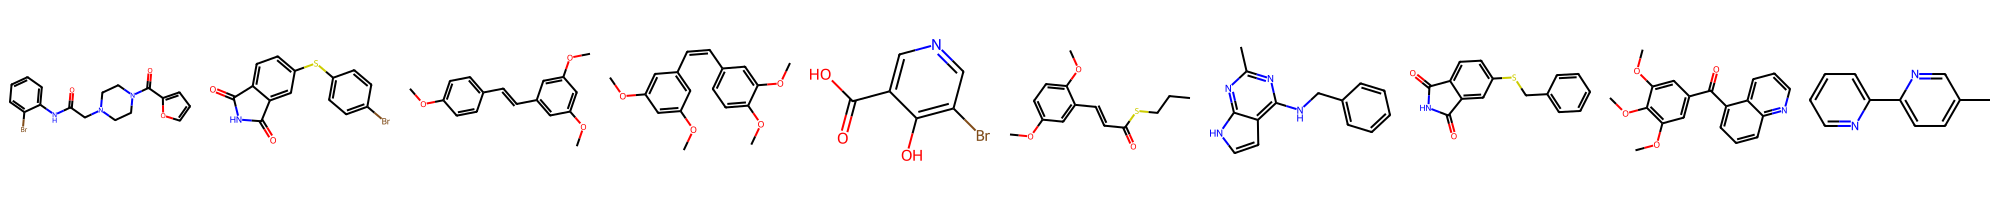

In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles
from rdkit import Chem
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

def generate_mol_image_with_qed(mol, qed_score):
    """Generate an image of a molecule with QED score below it."""
    # Generate the molecule image
    img = Draw.MolToImage(mol, size=(200, 200))

    # Convert the image to a format we can draw text on
    img = img.convert("RGBA")
    draw = ImageDraw.Draw(img)

    # Choose a font (you can modify the font size and style here)
    font = ImageFont.load_default()  # You can specify a TTF font file if desired
    text = f"QED: {qed_score:.3f}"  # Format the QED score

    # Define text position (just below the molecule image)
    text_position = (10, img.height - 20)  # Adjust as necessary
    draw.text(text_position, text, font=font, fill=(0, 0, 0))  # Draw text

    return img

from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import QED

def test_data(data_test):
    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)
    output, _, _ = model(data_test)

    # Decode the output
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # Print the first 10 decoded SMILES and the original (ground truth) data
    print("Original SMILES vs Sampled SMILES:")
    for i in range(10):
        # Print the decoded molecule (sampled by the model)
        decoded_smiles = decoded[i]
        # Convert one-hot encoded input data back to SMILES (original ground truth)
        original_smiles = decode_smiles_from_indexes(map(from_one_hot_array, data_test[i].cpu().numpy()), charset)

        # Print both original and sampled molecules
        print(f"Original: {original_smiles}")
        print(f"Sampled: {decoded_smiles}")
        print()

    # Calculate performance metrics
    rdBase.DisableLog('rdApp.*')
    frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count = calculate_mol_metrics(decoded)

    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')
    print(f'Average logP score: {avg_logP}')
    print(f'Average QED score: {avg_qed}')
    print(f'Average Synthetic Accessibility Score: {avg_sas}')
    print(f'Average Labute ASA score: {avg_labute_asa}')
    print(f'Total Lipinski Rule of 5 Passings: {lipinski_count}')

    # Draw the first 10 valid molecules with their QED scores
    valid_mols_with_qed = []
    for smi in decoded:
        mol = Chem.MolFromSmiles(smi)
        if mol:  # Only add valid molecules
            qed = QED.qed(mol)
            valid_mols_with_qed.append((mol, qed))

    # Sort by QED score (highest first)
    valid_mols_with_qed.sort(key=lambda x: x[1], reverse=True)

    # Take the top 10 molecules (highest QED)
    top_10_valid_mols = valid_mols_with_qed[:10]

    # Display the molecules in a grid
    mol_images = []
    for mol, qed in top_10_valid_mols:  # Top 10 molecules
        img = Draw.MolToImage(mol, size=(200, 200))
        mol_images.append(img)

    # Create a grid image of the molecules
    if mol_images:
        img_grid = Image.new('RGBA', (200 * len(mol_images), 200))
        for i, img in enumerate(mol_images):
            img_grid.paste(img, (i * 200, 0))

        # Display the final image
        display(img_grid)





# Assuming `RUN_ON_TEST_DATA` is set to `True`, run the test
if RUN_ON_TEST_DATA:
    test_data(data_test)


Blood Brain Barrier Analysis

SUGGEST NEW MOLECULES FROM LATENT SPACE

In [ ]:
# Suggest new molecules from latent space, validate, and calculate metrics
def suggest_molecules(model, num_mols=1000):
    z = torch.randn(num_mols, 292).to(device)
    output = model.decode(z)
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        # get charset in correct format from array of strings
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    frac_valid, avg_mol_wt, avg_logP, avg_qed, avg_sas, avg_labute_asa, lipinski_count = calculate_mol_metrics(decoded)
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')
    print(f'Average logP score: {avg_logP}')
    print(f'Average QED score: {avg_qed}')
    print(f'Average Synthetic Accessibility Score: {avg_sas}')
    print(f'Average Labute ASA score: {avg_labute_asa}')
    print(f'Total Lipinski Rule of 5 Passings: {lipinski_count}')

    # Draw the first 10 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
    print([d for d in decoded if Chem.MolFromSmiles(d)])
    dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
    display(dr_mol)

    return decoded

Num valid: 17 out of 1000 molecules
Fraction of valid molecules: 0.017
Average molecular weight: 203.11623529411767
Average logP score: 3.529795294117648
Average QED score: 0.4918863134148985
Average Synthetic Accessibility Score: 3.2753601033933926
Average Labute ASA score: 89.40243850506754
Total Lipinski Rule of 5 Passings: 17
['Cc1cc2ccccccccccccc12', 'Oc1ccc2cccccccccccc12', 'Clc1c(C)ccccnncnn2cccccc12', 'NCSSS', 'CCCc1cc(O)ccc(O)cc1', 'N', 'Cl', 'CCCCCCc1ccc(CC(O))cc1', 'CC(C(=O)O)c1ccc(OC(O)O)cc1', 'CC', 'CC/CCCCCCC=C/CCC/C=C/CCC\\C/CCCC\\CCC(=O)O', 'Cc1ccccccccccc1N', 'CCCCc1ccccc1O', 'c1ccc2ccccccc2ccc1', 'CCCCCCCCCCCCCCCCCCCCCCCCCC(C)CCCC(OO)O', 'COc1ccccc1OCCCCCCCCCC1CC1', 'CCC(C(C(COC)C(C)CC=O)C(C))OO']


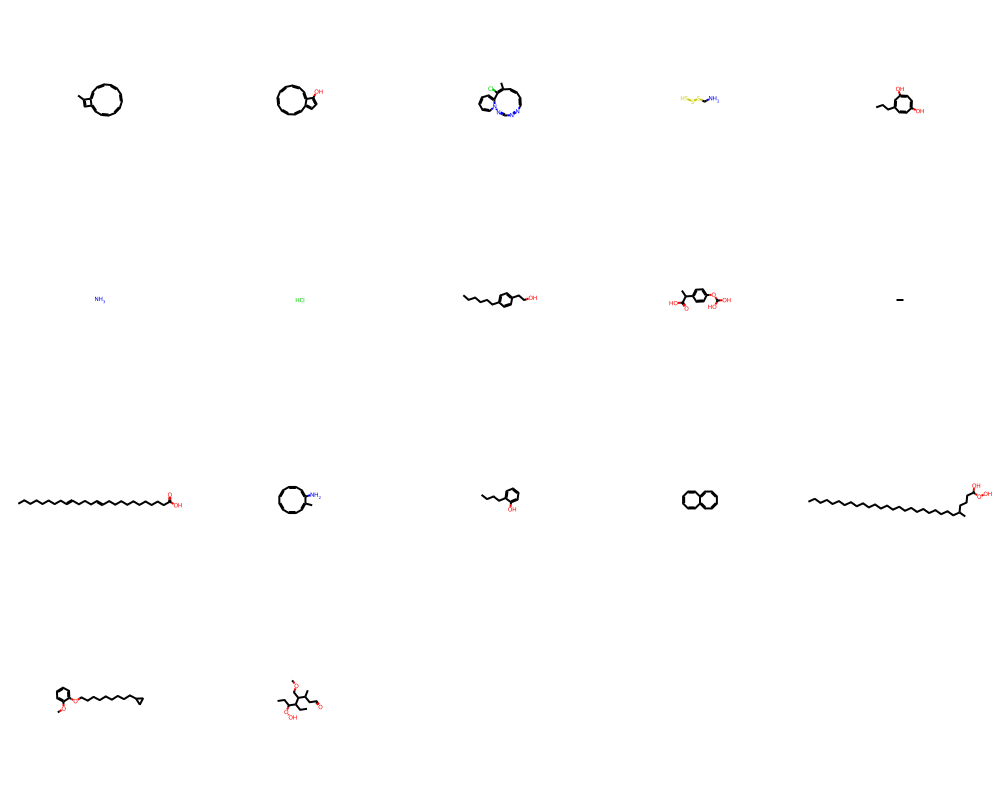

In [ ]:
if GENERATE_LATENT_SPACE_SMILES:
    # suggest new molecules and calculate metrics
    suggest_molecules(model)

other stuff

In [ ]:
# Predict smiles based on these external smiles as input
# Use model to predict and then evaluate the predicted molecules
import data_preprocessing as dp

# Evaluate other Smiles generated from external sources using this model
# Vocab must be less than or equal to charset_len for this model

def display_sample_smiles(smiles_file_path):

    # import sample smiles from SMILES_Dataset.csv
    smiles_data = pd.read_csv(smiles_file_path, header=0)
    # remove empty rows
    smiles_data = smiles_data.dropna()

    # evaluate sample smiles for validity and molecular weight
    frac_valid, avg_mol_wt = calculate_mol_metrics(smiles_data['Smiles'])
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')

    # Draw the first 20 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in smiles_data['Smiles'] if Chem.MolFromSmiles(s)]
    print(f"Valid smiles: {[d for d in smiles_data['Smiles'] if Chem.MolFromSmiles(d)]}")
    dr_mol = Draw.MolsToGridImage(valid_mols[:40], molsPerRow=5, subImgSize=(200, 200))
    print('Displaying input Sample Smiles: ')
    display(dr_mol)

    # send in charset_len
    # get h5 file from data_preprocessing
    data_path = dp.original_csv_to_ohe_h5(smiles_file_path, max_smiles_len=input_len, charset=charset)

    # load the data
    data_test, _ = load_dataset(data_path, split=False)

    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)

    output, _, _ = model(data_test)
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # print the first 10 decoded SMILES and the test data
        print()
        print(f'Original: {smiles_data["Smiles"].iloc[i]}')
        print(f'Predicted: {decoded[i]}')

    # calculate performance metrics
    rdBase.DisableLog('rdApp.*')
    try:
        frac_valid, avg_mol_wt = calculate_mol_metrics(decoded)
        print(f'Fraction of valid molecules: {frac_valid}')
        print(f'Average molecular weight: {avg_mol_wt}')

        # Draw the first 10 valid molecules
        valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
        print([d for d in decoded if Chem.MolFromSmiles(d)])
        dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
        print('Displaying Model Predicted Smiles from Sample Smiles as input:')
        display(dr_mol)
    except ZeroDivisionError:
        print('No valid molecules found')

In [ ]:
if EVAL_OTHER_SMILES:
    smiles_file_path = 'drive/My Drive/data/SMILES_Dataset.csv'
    display_sample_smiles(smiles_file_path)